In [1]:
import random
import nas_201_api as nb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
api = nb.NASBench201API(file_path_or_dict="API/NAS-Bench-201-v1_0-e61699.pth")
print(f"Number of architectures : {len(api)}")

try to create the NAS-Bench-201 api from API/NAS-Bench-201-v1_0-e61699.pth


In [3]:
for i in range(4):
    info_arch = api.get_net_config(i, dataset="cifar10-valid")
    arch = info_arch['arch_str']

    global_info = api.query_meta_info_by_index(i)
    accuracy = global_info.get_metrics('cifar10-valid', 'x-valid')['accuracy']


    print(f"Architecture string : {arch}")
    print(f"Architecture Accuracy : {accuracy}")
    print(f"")

Architecture string : |avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|
Architecture Accuracy : 81.98266665690103

Architecture string : |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|skip_connect~2|
Architecture Accuracy : 90.76933332438152

Architecture string : |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|
Architecture Accuracy : 81.91066666178385

Architecture string : |avg_pool_3x3~0|+|skip_connect~0|none~1|+|none~0|none~1|skip_connect~2|
Architecture Accuracy : 84.3773333203125



In [12]:
best_acc = 0
for i in range(len(api)):
    info_arch = api.get_net_config(i, dataset="cifar10-valid")
    global_info = api.query_meta_info_by_index(i)
    accuracy = global_info.get_metrics('cifar10-valid', 'x-valid')['accuracy']
    if accuracy>best_acc:
        best_acc=accuracy

print(f"Best accuracy : {best_acc}")

In [15]:
OPERATIONS = ["avg_pool_3x3", "nor_conv_1x1", "skip_connect", "nor_conv_3x3", "none"]
CHOICES_MUTATE = [1, 3, 4, 6, 7, 8]

In [16]:
architecture = "|"
for i in range(3):
    for j in range(i+1):
        op = random.choice(OPERATIONS)
        architecture += op + "~" + str(j) + "|"
    architecture+="+|"
architecture = architecture[:-2]

print(architecture)

|skip_connect~0|+|none~0|nor_conv_1x1~1|+|nor_conv_1x1~0|none~1|skip_connect~2|


In [17]:
index = api.query_index_by_arch(arch=architecture)
info = api.query_meta_info_by_index(index)
accuracy = info.get_metrics('cifar10-valid', 'x-valid')['accuracy']
print(accuracy)

86.19999999104817


In [18]:
class NB201Cell:
    def __init__(self, api, arch_str=None):

        self.api = api

        if arch_str is None:
            self.arch_str = self.initialise_arch_random()
        else:
            self.arch_str = arch_str

        self.index = self.api.query_index_by_arch(arch=self.arch_str)

    def get_val_acc(self):
        info = self.api.query_meta_info_by_index(self.index)
        accuracy = info.get_metrics('cifar10-valid', 'x-valid')['accuracy']
        return accuracy
    
    def initialise_arch_random(self):
        architecture = "|"
        for i in range(3):
            for j in range(i+1):
                op = random.choice(OPERATIONS)
                architecture += op + "~" + str(j) + "|"
            architecture+="+|"
        return architecture[:-2]
    
    def child_mutate(self):
        splitted = self.arch_str.split('|')
        random_index = random.choice(CHOICES_MUTATE)
        operation = splitted[random_index]
        link = operation.split('~')[-1]
        new_op = random.choice(OPERATIONS)
        new_op = new_op + "~" + link
        splitted[random_index] = new_op
        modified_arch_str = '|'.join(splitted)
        return NB201Cell(api=self.api, arch_str=modified_arch_str)

In [19]:
class RandomSearch:
    def __init__(self, api, num_iter=1000):

        self.api = api
        self.num_iter = num_iter

    def run(self):
        best_accs = []
        curr_best_acc=0
        for iter in range(self.num_iter):
            cell = NB201Cell(api=self.api)
            acc = cell.get_val_acc()
            if acc>=curr_best_acc:
                curr_best_acc=acc
            best_accs.append(curr_best_acc)
        return best_accs



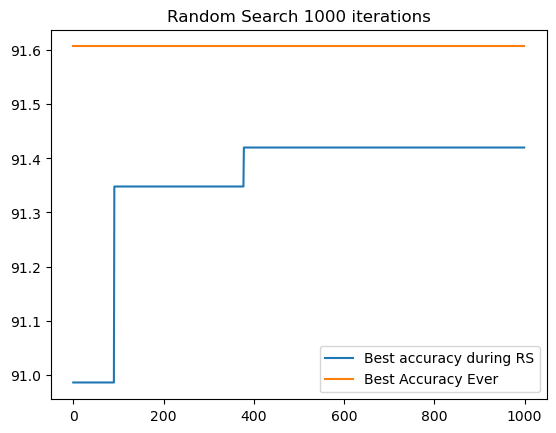

In [23]:
rs = RandomSearch(api=api)
best_accs_rs = rs.run()
plt.plot(best_accs_rs, label="Best accuracy during RS")
plt.plot(np.ones_like(best_accs_rs)*best_acc, label="Best Accuracy Ever")
plt.title("Random Search 1000 iterations")
plt.legend()

In [25]:
class RegularizedEvolution:
    def __init__(self, api, population_size=50, cycles=1000, sample_size=30):

        self.api = api
        self.population_size = population_size
        self.cycles = cycles
        self.sample_size = sample_size
        self.population = []
        self.history = []
        self.accuracies = []
        self.best_accs = [0.0]

    def initialize_population(self):
        while len(self.population) < self.population_size:
            random_cell = NB201Cell(api=self.api)
            self.population.append(random_cell)
            self.history.append(random_cell)
            new_acc = random_cell.get_val_acc()
            random_cell.acc = new_acc

            if new_acc > self.best_accs[-1]:
                self.best_accs.append(new_acc)
            else:
                self.best_accs.append(self.best_accs[-1])
    
    def evolve(self):
        while len(self.history) < self.cycles:
            samples = random.sample(self.population, self.sample_size)
            best_parent = max(samples, key=lambda cell: cell.acc)
            if best_parent.acc > self.best_accs[-1]:
                self.best_accs.append(best_parent.acc)
            else:
                self.best_accs.append(self.best_accs[-1])
            child = best_parent.child_mutate()
            child.acc = child.get_val_acc()
            self.population.append(child)
            self.history.append(child)
            self.population.pop(0)
    
    def run(self):
        self.initialize_population()
        self.evolve()
        return self.best_accs[1:]


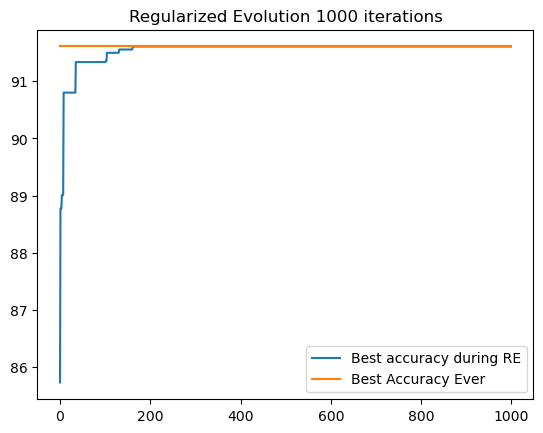

In [27]:
re = RegularizedEvolution(api=api, population_size=100, cycles=1000, sample_size=25)
best_accs_re = re.run()
plt.plot(best_accs_re, label="Best accuracy during RE")
plt.plot(np.ones_like(best_accs_re)*best_acc, label="Best Accuracy Ever")
plt.title("Regularized Evolution 1000 iterations")
plt.legend()
plt.show()

In [29]:
best_accs_re = []
best_accs_rs = []

rs = RandomSearch(api=api)
re = RegularizedEvolution(api=api, population_size=100, cycles=1000, sample_size=25)

for simu in range(10):

    rs = RandomSearch(api=api)
    re = RegularizedEvolution(api=api, population_size=100, cycles=1000, sample_size=25)

    best_accs_re.append(re.run())
    best_accs_rs.append(rs.run())
    print(f"Simu {simu} done")

Simu 0 done
Simu 1 done
Simu 2 done
Simu 3 done
Simu 4 done
Simu 5 done
Simu 6 done
Simu 7 done
Simu 8 done
Simu 9 done


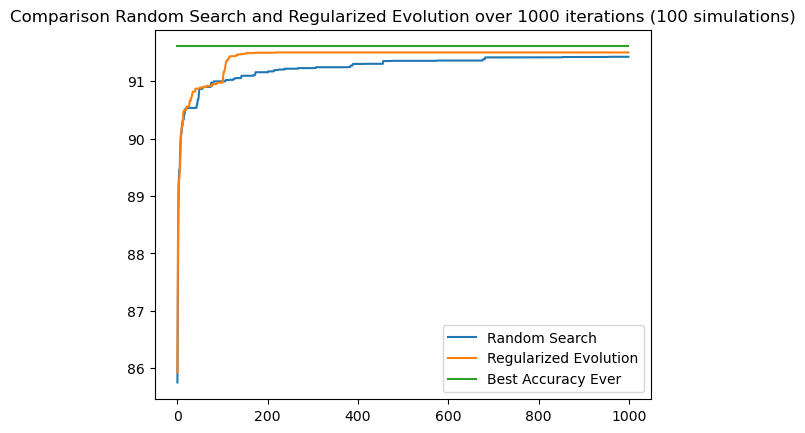

In [30]:
best_accs_re = np.mean(best_accs_re, axis=0)
best_accs_rs = np.mean(best_accs_rs, axis=0)

plt.plot(best_accs_rs, label="Random Search")
plt.plot(best_accs_re, label="Regularized Evolution")
plt.plot(np.ones_like(best_accs_re)*best_acc, label="Best Accuracy Ever")
plt.title('Comparison Random Search and Regularized Evolution over 1000 iterations (100 simulations)')
plt.legend()